# **In-Class Activity Topic 5** - Supervised Document Classification
## *DATA 5420/6420*
## Name: Patrick Neyland

In this in-class exercise we will train several supervised classifiers to predict the genre label on the Brown corpus. We will also utilize grid searching to help determine optimal parameters for a final model. Once we've decided on a final model, we will apply it to a toy corpus of short texts and predict their genre.

We begin as always, by loading in our dependencies:

In [36]:
# Import necessary libraries
import nltk
import re
from nltk.corpus import brown
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Download the nltk features
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# ignore warnings
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Patri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Patri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Patri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('combined_paragraphs_brown.csv')
df.head()

,doc_para_id,label,combined_tokenized_text
0,ca01_0,news,The Fulton County Grand Jury said Friday an in...
1,ca01_1,news,The jury further said in term-end presentments...
2,ca01_10,news,It urged that the next Legislature `` provide ...
3,ca01_11,news,The grand jury took a swipe at the State Welfa...
4,ca01_12,news,`` This is one of the major items in the Fulto...


In [3]:
len(df)

15667

## Peform any necessary cleaning and text normalization

In [4]:
# Text normalization function
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Apply text normalization to the 'text' column
df['clean_text'] = df['combined_tokenized_text'].apply(normalize_text)

In [5]:
#df.to_csv('Cleaned_Brown.csv')
df = pd.read_csv('Cleaned_Brown.csv')
df.head()

,Unnamed: 0,doc_para_id,label,combined_tokenized_text,clean_text
0,0,ca01_0,news,The Fulton County Grand Jury said Friday an in...,fulton county grand jury said friday investiga...
1,1,ca01_1,news,The jury further said in term-end presentments...,jury said termend presentment city executive c...
2,2,ca01_10,news,It urged that the next Legislature `` provide ...,urged next legislature provide enabling fund r...
3,3,ca01_11,news,The grand jury took a swipe at the State Welfa...,grand jury took swipe state welfare department...
4,4,ca01_12,news,`` This is one of the major items in the Fulto...,one major item fulton county general assistanc...


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15667 entries, 0 to 15666
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               15667 non-null  int64 
 1   doc_para_id              15667 non-null  object
 2   label                    15667 non-null  object
 3   combined_tokenized_text  15667 non-null  object
 4   clean_text               15622 non-null  object
dtypes: int64(1), object(4)
memory usage: 612.1+ KB


In [11]:
df = df.dropna()

## Let's examine the breakdown of the genre labels...

What are the most common genres in this dataset, which are the least? What impact might this have on the predictive accuracy of the models we train?

In [6]:
# examine labels
df['label'].value_counts()

news               2234
learned            1418
belles_lettres     1405
adventure          1387
romance            1253
lore               1203
mystery            1164
hobbies            1119
fiction            1043
editorial          1003
government          851
reviews             629
religion            369
science_fiction     335
humor               254
Name: label, dtype: int64

The impact of having uneven class distribution is that we may have differential performance among our various genre labels. 

## Split the data into a training and test set

In [12]:
# Split data into text and labels
texts = df['clean_text'].tolist()
labels = df['label'].tolist()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

## Peform feature engineering by vectorizing the text with TF-IDF

Let's set `min_df` and `max_df` to limit the number of features, then we'll check to see how many features we have in our dataset:

In [25]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english', min_df = 1, max_df = 0.80)
X_train_vec = vectorizer.fit_transform(X_train) # will determine the number of features
X_test_vec = vectorizer.transform(X_test) # will use the same number of features as X_train_vec

num_features = X_train_vec.shape
num_features

(12497, 36120)

In [26]:
X_test_vec.shape

(3125, 36120)

## Now let's train a few supervised classifiers using our training set

In [29]:
# Define and train models
models = {
        "Naive Bayes": MultinomialNB(),
        "Linear SVM": LinearSVC(),
        "Random Forest": RandomForestClassifier(random_state=42)
}

for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

Naive Bayes Accuracy: 0.4746


c:\Users\Patri\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Linear SVM Accuracy: 0.6842
Random Forest Accuracy: 0.4861


## We'll drop out random forests since it's slow and not performing well, let's do some cross-validation on our remaining models...

In [32]:
models = {
    'Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC()
}

# Perform cross-validation for each model
for name, model in models.items():
    scores = cross_val_score(model, X_train_vec, y_train, cv = 5 )
    print(f"{name} Cross-Validation Mean Accuracy: {scores.mean():.4f}")

Naive Bayes Cross-Validation Mean Accuracy: 0.4688


c:\Users\Patri\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Patri\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Patri\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Patri\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Patri\anaconda3\Lib\site-packages\sklearn\svm\_clas

Linear SVM Cross-Validation Mean Accuracy: 0.6868


**Is there a significant difference in the CV accuracy for the models vs the training accuracy?**

No. They are quite similar. Which is great!

## Finally, let's select the best performing model and perform a CV grid search to select optimal parameters

In [37]:
param_grid_svc = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge'],
    'max_iter': [1000, 5000, 10000]
}

# Grid search for LinearSVC
grid_search_svc = GridSearchCV(LinearSVC(), param_grid_svc, verbose = 10)
grid_search_svc.fit(X_train_vec, y_train)

# After fitting, you would typically print the best parameters as follows:
print("Best parameters for LinearSVC:", grid_search_svc.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5; 1/30] START C=0.001, loss=hinge, max_iter=1000.........................
[CV 1/5; 1/30] END C=0.001, loss=hinge, max_iter=1000;, score=0.631 total time=   0.0s
[CV 2/5; 1/30] START C=0.001, loss=hinge, max_iter=1000.........................
[CV 2/5; 1/30] END C=0.001, loss=hinge, max_iter=1000;, score=0.645 total time=   0.0s
[CV 3/5; 1/30] START C=0.001, loss=hinge, max_iter=1000.........................
[CV 3/5; 1/30] END C=0.001, loss=hinge, max_iter=1000;, score=0.642 total time=   0.0s
[CV 4/5; 1/30] START C=0.001, loss=hinge, max_iter=1000.........................
[CV 4/5; 1/30] END C=0.001, loss=hinge, max_iter=1000;, score=0.650 total time=   0.0s
[CV 5/5; 1/30] START C=0.001, loss=hinge, max_iter=1000.........................
[CV 5/5; 1/30] END C=0.001, loss=hinge, max_iter=1000;, score=0.635 total time=   0.0s
[CV 1/5; 2/30] START C=0.001, loss=hinge, max_iter=5000.........................
[CV 1/5; 2/30] EN

## Now apply the final model to the test set, and produce a confusion matrix and classification report:

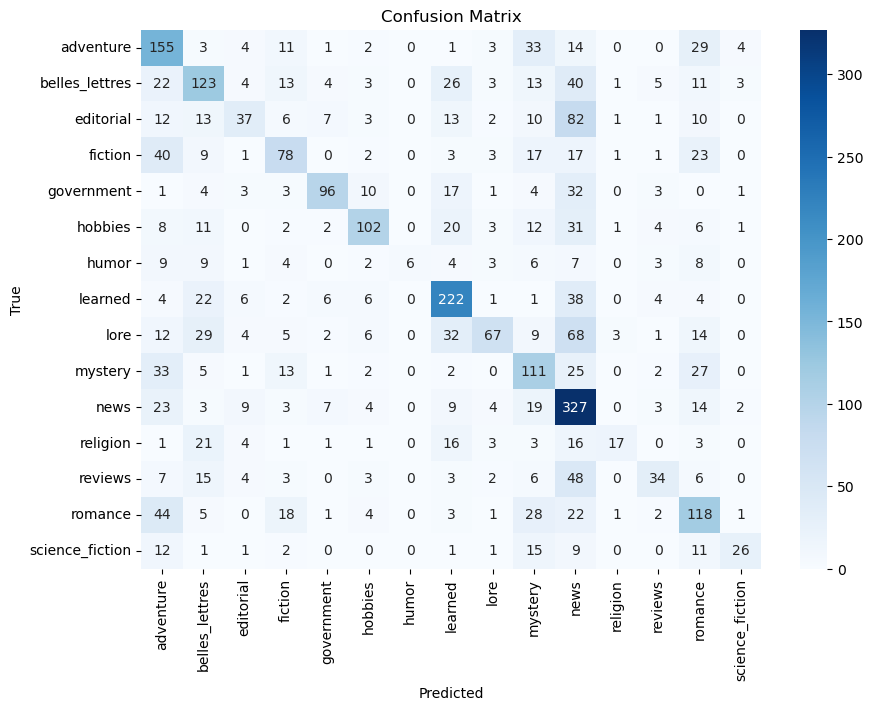


Classification Report:



In [38]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = sorted(list(set(y_test)))

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print()

**Which categories were commonly confused, and is that surprising?**

**Which metric(s) might we choose to evaluate our model's performance based on for this dataset and why?**

## As a final step, I've provide three different new texts I pulled from various sources, let's see how our model works in predicting labels on these unseen texts...

In [ ]:
# Toy corpus
toy_corpus = [
    "On Tuesday, the Organisation for Economic Cooperation and Development (OECD) published its latest outlook for the global economy. Describing the prospects for growth as “weak”, with risks “tilted to the downside”, the OECD singled out two worrying trends.",
    "His mother’s roses were in full bloom, red and pink and riotous, just the way they all liked them, and as Nicholas drew close, he felt their scent in the damp air, drifting lightly over his clothes and under his nose. He’d never been particularly fond of the smell of roses—he preferred his flowers less fussy—but when everything came together in moments like this: the roses and the mist, the damp of the earth…",
    "Ah sinful nation, a people laden with iniquity, a seed of evildoers, children that are corrupters: they have forsaken the LORD, they have provoked the Holy One of Israel unto anger, they are gone away backward."
]

# Vectorize and predict using the best model
toy_corpus_vec =
num_features =
num_features


**Why is it important that we use the same number of features here as we did for the training corpus?**

In [ ]:
predicted_labels =

for text, label in zip(toy_corpus, predicted_labels):
    print(f"'{text}' is predicted as '{label}' category.")

**Did the model seem to apply the correct label for the toy corpus?**